# Interpolación, extrapolación y modelización:

## Interpolación

 Tenemos una serie de datos y queremos dar un valor a un punto intermedio.



In [6]:
import numpy as np
import matplotlib.pyplot as plt

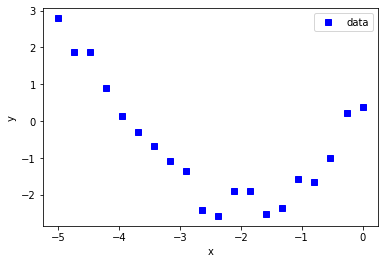

In [7]:
Data = np.loadtxt('data/Data1_modelling.txt') # 3 columnas, x, y , yerr
x = Data[:,0]; y = Data[:,1]
plt.plot(x, y, 's',label='data',color='b')
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

Podemos interpolar nosotros haciendo un promedio de los valores contiguos. Por ejemplo si queremos añadir un punto entre los dos primeros, calculamos el valor medio tanto entre x[0] y x[1] como de y[0] e y[1]

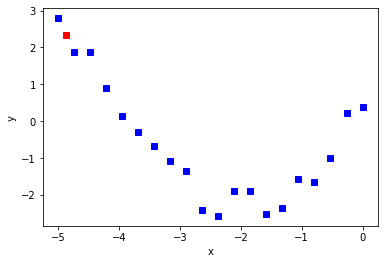

In [8]:
# queremos saber valor en el
# valor medio de los valores contiguos
valy=(y[0]+y[1])/2
valx=(x[0]+x[1])/2
plt.plot(x, y, 's',label='data',color='b')
plt.plot(valx,valy,'rs')
plt.xlabel('x');
plt.ylabel('y');


De manera general, lo que hacemos es trazar una recta entre los dos puntos. Y hacemos esto para cada par de puntos, de manera que hacemos la interpolación poco suave. Esta interpolación es solo válida cuando tenemos puntos muy cercanos. Para otro tipo de interpolaciones usamos más de un número contiguo. 

En **Python** podemos usar `interp1d` del paquete `scipy.interpolate` para hacerlo de distintas maneras. 

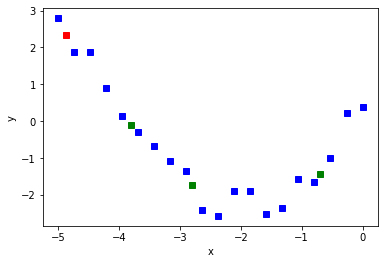

In [9]:
from scipy.interpolate import interp1d
f = interp1d(x, y) # kind='linear','cubic','cuadratic',... (por defecto linear)
# interp1d entre cada 2 puntos se ha estimado una recta
plt.plot(x, y, 's',label='data',color='b')
plt.plot(valx, f(valx), 'rs')
plt.plot(-3.8, f(-3.8), 'gs')
plt.plot(-2.8, f(-2.8), 'gs')
plt.plot(-0.7, f(-0.7), 'gs')
plt.xlabel('x');
plt.ylabel('y');


## Extrapolación
Ahora vamos a intentar predecir un valor fuera de los datos que tenemos:

In [10]:
# Extrapolamos
yval = f(1)
plt.plot(1, yval, 'ks')  # Falla ! no sabe extrapolar

ValueError: A value in x_new is above the interpolation range.

Con `interp1d` podemos indicar que extrapole:

0.752295194488923


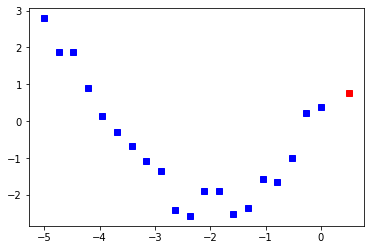

In [11]:
f = interp1d(x, y, fill_value='extrapolate')
yval=f(0.5)
print(yval)
plt.plot(x, y, 's', label='data', color='b')
plt.plot(0.5, yval, 'rs');

Lo que ha hecho es trazar la recta (u otra curva que indiquemos) con los dos (o más) últimos puntos y extrapola en base a eso. Vemos el caso lineal aquí: 

yval     0.7522951944889229
interp1d 0.752295194488923


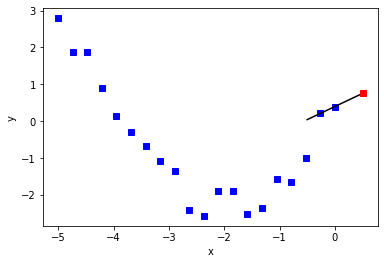

In [12]:
a = (y[-1]-y[-2])/(x[-1]-x[-2])
b = y[-1]-x[-1]*a
# calculamos valor de la distancia a las 10 horas
yval = a * 0.5 + b
print('yval    ', yval)
print('interp1d', f(0.5))
x3 = np.arange(-0.5, 0.6, 0.1)
plt.plot(x, y, 's',label='data',color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x3, a * x3 + b,'k');
plt.plot(0.5, yval, 'rs');

## Modelización
Lo ideal sería usar todos los datos para sacar un **modelo**. Lo ideal sería tener una idea de como se comportan los datos. Si no la tenemos, siempre podemos ajustar a un polinomio. Nuestro datos parece que se comportan como una parábola, probamos con un polinomio de grado 2 usando `polyfit`:

a= 0.5986 b= 2.4025 c= 0.2347
        2
0.5986 x + 2.402 x + 0.2347


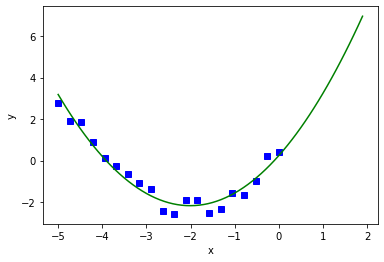

In [13]:
par = np.polyfit(x, y, 2)
print('a=', np.round(par[0],4), 'b=', np.round(par[1],4), 'c=', np.round(par[2],4))
obj = np.poly1d(par)  # guarda la funcion obj=a[2]*x^2+a[1]*x+a[0]*x
print(obj)
plt.plot(x, y, 's',label='data', color='b')
x3 = np.arange(-5, 2, 0.1)
# ahora ya podemos extrapolar
plt.plot(x3,obj(x3),'g')

plt.xlabel('x');
plt.ylabel('y');

Una vez tengamos un modelo basado en unos datos es **MUY IMPORTANTE** testarlo en **datos independientes**. Recogemos más datos y los comparamos con las predicciones de nuestro modelo. 

NameError: name 'obj' is not defined

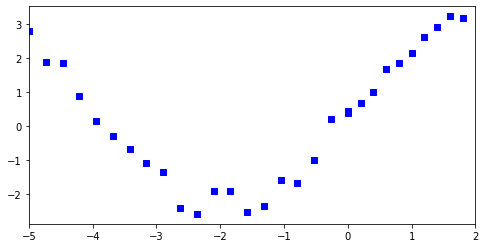

In [4]:
# En data2_modelling tenemos datos recogidos de unas horas más tarde
plt.figure(0,figsize=(8,4))
Data2 = np.loadtxt('data/Data2_modelling.txt')
x2 = Data2[:,0]; y2 = Data2[:,1]
x3 = np.concatenate((x, x2)) # en un mismo array todos los datos
y3 = np.concatenate((y, y2)) # en un mismo array todos los datos

plt.plot(x3[:30], y3[:30], 's', color='b', label='data')
plt.xlim(-5, 2)
# el modelo ya no ajusta
xaux = np.arange(-5, 5, 0.1)
plt.plot(xaux, obj(xaux), color='g')
plt.plot(0.5, obj(0.5), 'sr')
plt.ylim(-5, 5);


Los **modelos empíricos** no suelen funcionar **fuera del rango** donde hemos ajustado el modelo. Mientras que los modelos teóricos son válidos para cualquier valor de las variables.

El caso de las mareas tiene un modelo téorico basado en la ley de la gravedad que sirve para hacer predicciones acertadas en cualquier momento del año. Pero a veces no tenemos esa información, lo que si solemos poder averiguar es que comportamiento tiene recogiendo el número suficiente de datos. Por ejemplo, si vemos que tiene una componente cíclica podemos probar con modelos **sinusoidales**. Para una función más general usamos `curve_fit` del paquete `scipy.optimize`

results [2.83 0.8 ]


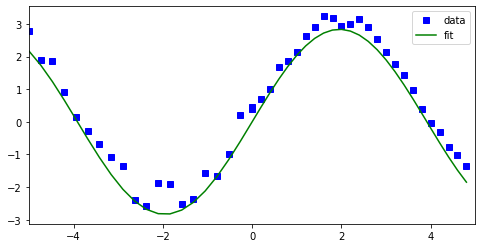

In [40]:
import scipy.optimize as opt


# definimos el modelo en una función, con parámetros de entrada 
# la variables y los parámetros libres
def func(x, a, b):
     return a * np.sin(b*x)

# hacemos ajuste por mínimos cuadrados usando curve_fit
popt, pcov = opt.curve_fit(func, x3, y3)#,p0=(0.5,0.5,0.5))
# esto nos devolverá los parametros a,b y c
print('results',np.round(popt,2))

a = popt[0]; b = popt[1]
model = func(x3, a, b)

plt.figure(0,figsize=(8,4))
plt.plot(x3, y3, 's', color='b', label='data')
plt.plot(x3, model, '-', color='g', label='fit')
plt.xlim(-5,5)


#model2 = func(x3, 3.1, 0.9)   # lo puedo comparar con los parámetros que alguien calculó previamente
#plt.plot(x3, model2,'-', color='r', label='old model')

plt.legend();

Parece que esto ya se ajusta más. Y suele ser mejor si añadimos información del ruido, podemos dar esta información en `curve_fit`


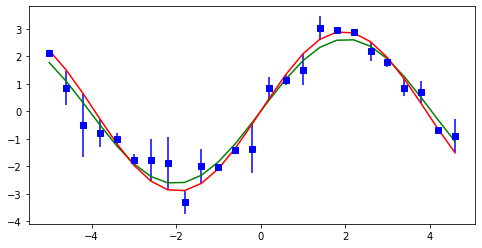

In [49]:
# añadimos información del ruido
Data2 = np.loadtxt('data/Data2_modelling_noisy.txt')
x = Data2[:,0]; y = Data2[:,1]; yerr = Data2[:,2]
plt.figure(0,figsize=(8,4))
# volvemos a hacer fit
popt, pcov = opt.curve_fit(func, x, y)
# añadimos información del error
poptErr, pcov = opt.curve_fit(func, x, y, sigma=yerr)
# esto nos devolverá los parametros a y b
plt.errorbar(x, y, yerr=yerr,  marker='s',color='b',label='data',linestyle='')
a = popt[0]; b = popt[1]
model = func(x,a,b)
modelErr = func(x, *poptErr)
plt.plot(x, model, '-', color='g');
plt.plot(x, modelErr,'-', color='r');


In [51]:
print('results    ',np.round(popt,2))
print('results Err',np.round(poptErr,2))
print('True val   ', 2.9, 0.8)
print('Resultado más parecidos a los reales con poptErr')

results     [2.63 0.78]
results Err [2.91 0.8 ]
True val    2.9 0.8
Resultado más parecidos a los reales con poptErr


## Ejercicios para paracticar

1. Practicaremos ajustar con polyfit y de paso repasamos cosas dadas en anteriores clases:

* Define este polinomio de orden 3 usando numpy.poly1d o definiendo la función              
 
* Simula unos datos, alrededor de 20 puntos con:
   - x  números aleatorios entre -10 y 10  siguiendo una distribución uniforme. 
   - y = pol(x, a, b, c) con a,b y c que quierea + un ruido Gaussiano con un ruido Gaussiano con dispersion=25
 
* Haz un ajuste usando polyfit, compara valores que obtienes con los que has metido.  

* Haz plot de los datos y del ajuste. (Recuerda poner la leyenda)

* Calcula el $\chi^2$ de tu ajuste (mira la equación en la teoría) y calcula P(X>x) usando la función de distribución de $\chi^2$ con los grados de libertad de este problema (usa scipy.stats.chi2, (P(X>x) = 1-P(X<=x).) 

* Muestra en un plot la distribución $\chi^2$ con una línea vertical con el valor que obtienes del ajuste. 



In [ ]:
# respuesta

2. Carga los datos en Data_exp.txt 

* Haz un ajuste usando `curve_fit` suponiendo que la función del modelo es: $ y = ae^{b\sin{fx+\theta}}$

* Haz plot de los datos y del ajuste (con leyenda). 

* Busca el polinomio de grado mínimo que da un buen ajuste para estos datos. (Calcula mse para cada polinomio ajustado)

* Compara los resultados usando el polinomio y la función anterior. 

* Carga los datos extendidos: Data_exp_large.txt y usálo para comprobar si tus modelos se ajustan a los nuevos datos.

In [90]:
# Código
True_param = [3, 2, 1, np.pi/4]  # valores reales del modelo que se han usado para los datos Data_exp.txt
                                 # por si quieres comparar con lo que saques. 

3. Modifica el siguiente código para mejorar el fit de los datos. Primero hay que encontrar la peculiaridad del modelo y buscar en `help(opt.curve_fit)` o directamente en [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) para resolverlo. 

[1.1472383  3.05663278 0.95633142]


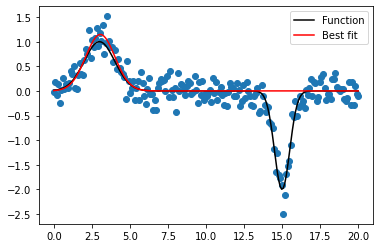

In [5]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as mpl

# Let's create a function to model and create data
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Generating clean data
x = np.linspace(0, 20, 200)
y1 = func(x[np.where(x <= 10)], 1, 3, 1)
y2 = func(x[(x > 10)], -2, 15, 0.5)

y = np.hstack([y1, y2])

# Adding noise to the data
yn = y + 0.2 * np.random.normal(size=len(x))

# Plot out the current state of the data and model
fig = mpl.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, c='k', label='Function')
ax.scatter(x, yn)

# Executing curve_fit on noisy data
popt, pcov = curve_fit(func, x, yn)

#popt returns the best fit values for parameters of the given model (func)
print(popt)

ym = func(x, popt[0], popt[1], popt[2])
ax.plot(x, ym, c='r', label='Best fit')

ax.legend();
